# %% [markdown]

 # News Article Clustering Tutorial

# %% [markdown]

 ## 1. Environment Setup

In [ ]:
# %%

!pip install openai pandas numpy scikit-learn kneed nest_asyncio python-dotenv tiktoken ipywidgets

# %% [markdown]

 ## 2. Configuration Setup

In [ ]:
# %%

import os
from dotenv import load_dotenv
load_dotenv(".env")

class Config:
    OPENAI_API_KEY = None  # Set the key here or leave as None to use the one from .env
    EMBEDDING_MODEL = "text-embedding-3-small"
    LLM_MODEL = "gpt-3.5-turbo"
    MAX_TOKENS = 8192
    CLUSTER_RANGE = range(2, 11)
    SEED = 42
    
    @classmethod
    def verify_key(cls):
        """Validate API key presence"""
        key = cls.OPENAI_API_KEY or os.getenv("OPENAI_API_KEY")
        if not key:
            raise ValueError("No API key found in Config or .env")
        return key

print("Configuration loaded. Key status:", "✅ Valid" if Config.verify_key() else "❌ Missing")

Configuration loaded. Key status: ✅ Valid


# %% [markdown]

 ## 3. Initialize Environment

In [ ]:
# %%

import nest_asyncio
import numpy as np
import pandas as pd
from openai import AsyncOpenAI

# Async setup
nest_asyncio.apply()
aclient = AsyncOpenAI(api_key=Config.verify_key())

# %% [markdown]

 ## 4. Data Loading

In [ ]:
# %%

# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

In [ ]:
# %%

# Load dataset
file_name = "data/news-watch-ketegangan perdagangan-sd-2024-01.csv"
df = pd.read_csv(file_name)

# Data preprocessing
df = df.drop_duplicates(subset=["keyword", "source", "link"])
df["content"] = df["content"].fillna("").astype(str)

df

,title,publish_date,author,content,keyword,category,source,link
0,"Sempat Terbang, Emas Hancur Bersama Mundurnya ...",2024-07-23 06:50:00,"Chandra Dwi,CNBC Indonesia","Jakarta, CNBC Indonesia\n- Harga emas ditutup ...",ketegangan perdagangan,Berita Research,cnbcindonesia.com,https://www.cnbcindonesia.com/research/2024072...
1,"Breaking! Harga Emas Tembus Rekor Baru, Mepet ...",2025-02-10 14:06:00,"mae,CNBC Indonesia","Jakarta, CNBC Indonesia\n- Harga emas tembus r...",tarif trump,Berita Research,cnbcindonesia.com,https://www.cnbcindonesia.com/research/2025021...
2,"Perdagangan Internasional: Pengertian, Manfaat...",2024-05-03 07:00:00,Nur Wasilatus Sholeha -detikEdu,Daftar Isi\nPengertian Perdagangan Internasion...,perang tarif,detikEdu,detik.com,https://www.detik.com/edu/detikedu/d-7321635/p...
3,"Serangan Israel Tidak Mempan ke Iran, Harga Mi...",2024-10-28 10:35:00,"Robertus Andrianto,CNBC Indonesia","Jakarta, CNBC Indonesia -\nHarga minyak mentah...",ketegangan perdagangan,Berita Market,cnbcindonesia.com,https://www.cnbcindonesia.com/market/202410280...
4,"7 Fakta Pemilu AS 2024, Siapa yang Dunia Mau J...",2024-11-05 15:05:00,"Tommy Patrio Sorongan,CNBC Indonesia","Jakarta, CNBC Indonesia\n-\nAmerika Serikat (A...",perang tarif,Berita,cnbcindonesia.com,https://www.cnbcindonesia.com/news/20241105144...
...,...,...,...,...,...,...,...,...
4436,"Isi Lengkap Perang Dagang 2.0 Trump, Tarif Ber...",2025-02-03 08:55:00,"Thea Fathanah Arbar,CNBC Indonesia","Jakarta, CNBC Indonesia\n- Presiden Amerika Se...",perang tarif,Berita,cnbcindonesia.com,https://www.cnbcindonesia.com/news/20250203075...
4437,"Bangga! Lewat Nikel, RI Bakal Punya Peran Stra...",2024-10-29 12:40:00,"Firda Dwi Muliawati,CNBC Indonesia","Jakarta, CNBC Indonesia -\nHolding BUMN Pertam...",perang tarif,Berita,cnbcindonesia.com,https://www.cnbcindonesia.com/news/20241029121...
4438,"Cegah Serbuan Produk China ke AS, Biden Mau Na...",2024-04-18 08:45:00,Aulia Damayanti -detikFinance,Jakarta\n-\nPresiden Amerika Serikat (AS) Joe ...,tarif China,detikFinance,detik.com,https://finance.detik.com/berita-ekonomi-bisni...
4439,Putar Otak Siasati Ancaman Perang Dagang AS-Ch...,2025-01-15 12:55:00,Amanda Christabel -detikFinance,Jakarta\n-\nPemerintah mengatakan kekhawatiran...,tarif AS,detikFinance,detik.com,https://finance.detik.com/berita-ekonomi-bisni...


# %% [markdown]

 ## 5. Text Processing

In [ ]:
# %%

import tiktoken

def safe_truncate(text: str) -> str:
    """Ensure text fits model's token limit"""
    enc = tiktoken.get_encoding("cl100k_base")
    tokens = enc.encode(text)[:Config.MAX_TOKENS]
    return enc.decode(tokens)

df["processed_content"] = df["content"].apply(safe_truncate)
df

,title,publish_date,author,content,keyword,category,source,link,processed_content
0,"Sempat Terbang, Emas Hancur Bersama Mundurnya ...",2024-07-23 06:50:00,"Chandra Dwi,CNBC Indonesia","Jakarta, CNBC Indonesia\n- Harga emas ditutup ...",ketegangan perdagangan,Berita Research,cnbcindonesia.com,https://www.cnbcindonesia.com/research/2024072...,"Jakarta, CNBC Indonesia\n- Harga emas ditutup ..."
1,"Breaking! Harga Emas Tembus Rekor Baru, Mepet ...",2025-02-10 14:06:00,"mae,CNBC Indonesia","Jakarta, CNBC Indonesia\n- Harga emas tembus r...",tarif trump,Berita Research,cnbcindonesia.com,https://www.cnbcindonesia.com/research/2025021...,"Jakarta, CNBC Indonesia\n- Harga emas tembus r..."
2,"Perdagangan Internasional: Pengertian, Manfaat...",2024-05-03 07:00:00,Nur Wasilatus Sholeha -detikEdu,Daftar Isi\nPengertian Perdagangan Internasion...,perang tarif,detikEdu,detik.com,https://www.detik.com/edu/detikedu/d-7321635/p...,Daftar Isi\nPengertian Perdagangan Internasion...
3,"Serangan Israel Tidak Mempan ke Iran, Harga Mi...",2024-10-28 10:35:00,"Robertus Andrianto,CNBC Indonesia","Jakarta, CNBC Indonesia -\nHarga minyak mentah...",ketegangan perdagangan,Berita Market,cnbcindonesia.com,https://www.cnbcindonesia.com/market/202410280...,"Jakarta, CNBC Indonesia -\nHarga minyak mentah..."
4,"7 Fakta Pemilu AS 2024, Siapa yang Dunia Mau J...",2024-11-05 15:05:00,"Tommy Patrio Sorongan,CNBC Indonesia","Jakarta, CNBC Indonesia\n-\nAmerika Serikat (A...",perang tarif,Berita,cnbcindonesia.com,https://www.cnbcindonesia.com/news/20241105144...,"Jakarta, CNBC Indonesia\n-\nAmerika Serikat (A..."
...,...,...,...,...,...,...,...,...,...
4436,"Isi Lengkap Perang Dagang 2.0 Trump, Tarif Ber...",2025-02-03 08:55:00,"Thea Fathanah Arbar,CNBC Indonesia","Jakarta, CNBC Indonesia\n- Presiden Amerika Se...",perang tarif,Berita,cnbcindonesia.com,https://www.cnbcindonesia.com/news/20250203075...,"Jakarta, CNBC Indonesia\n- Presiden Amerika Se..."
4437,"Bangga! Lewat Nikel, RI Bakal Punya Peran Stra...",2024-10-29 12:40:00,"Firda Dwi Muliawati,CNBC Indonesia","Jakarta, CNBC Indonesia -\nHolding BUMN Pertam...",perang tarif,Berita,cnbcindonesia.com,https://www.cnbcindonesia.com/news/20241029121...,"Jakarta, CNBC Indonesia -\nHolding BUMN Pertam..."
4438,"Cegah Serbuan Produk China ke AS, Biden Mau Na...",2024-04-18 08:45:00,Aulia Damayanti -detikFinance,Jakarta\n-\nPresiden Amerika Serikat (AS) Joe ...,tarif China,detikFinance,detik.com,https://finance.detik.com/berita-ekonomi-bisni...,Jakarta\n-\nPresiden Amerika Serikat (AS) Joe ...
4439,Putar Otak Siasati Ancaman Perang Dagang AS-Ch...,2025-01-15 12:55:00,Amanda Christabel -detikFinance,Jakarta\n-\nPemerintah mengatakan kekhawatiran...,tarif AS,detikFinance,detik.com,https://finance.detik.com/berita-ekonomi-bisni...,Jakarta\n-\nPemerintah mengatakan kekhawatiran...


# %% [markdown]

 ## 6. Embedding Generation

In [ ]:
# %%

import asyncio
from tqdm.notebook import tqdm

async def generate_embeddings(texts: list) -> list:
    """Batch process embeddings with progress tracking"""
    embeddings = []
    for i in tqdm(range(0, len(texts), 100), desc="Generating Embeddings"):
        batch = texts[i:i+100]
        results = await asyncio.gather(*[
            aclient.embeddings.create(input=t, model=Config.EMBEDDING_MODEL)
            for t in batch
        ])
        embeddings.extend([r.data[0].embedding for r in results])
    return embeddings

# Execute async embedding generation
df["embeddings"] = asyncio.run(generate_embeddings(df["processed_content"].tolist()))
print("Embeddings generated. Shape:", np.array(df["embeddings"].tolist()).shape)

Generating Embeddings:   0%|          | 0/44 [00:00<?, ?it/s]

Embeddings generated. Shape: (4383, 1536)


# %% [markdown]

 ## 7. Clustering Setup

In [ ]:
# %%

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

# Prepare embedding matrix
matrix = np.vstack(df["embeddings"].values)
print("Embedding matrix shape:", matrix.shape)

Embedding matrix shape: (4383, 1536)


In [ ]:
# %%

# Calculate clustering metrics
inertias = []
silhouettes = []

for n in Config.CLUSTER_RANGE:
    kmeans = KMeans(n_clusters=n, random_state=Config.SEED).fit(matrix)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(matrix, kmeans.labels_))

# Auto-detect optimal clusters
knee = KneeLocator(Config.CLUSTER_RANGE, inertias, curve='convex', direction='decreasing')
optimal_clusters = knee.elbow or 5  # Fallback to 5 if not detected

print(f"Optimal clusters detected: {optimal_clusters} (Inertia: {inertias[optimal_clusters-2]:.2f})")

Optimal clusters detected: 7 (Inertia: 1652.93)


# %% [markdown]

 ## 8. Cluster Visualization

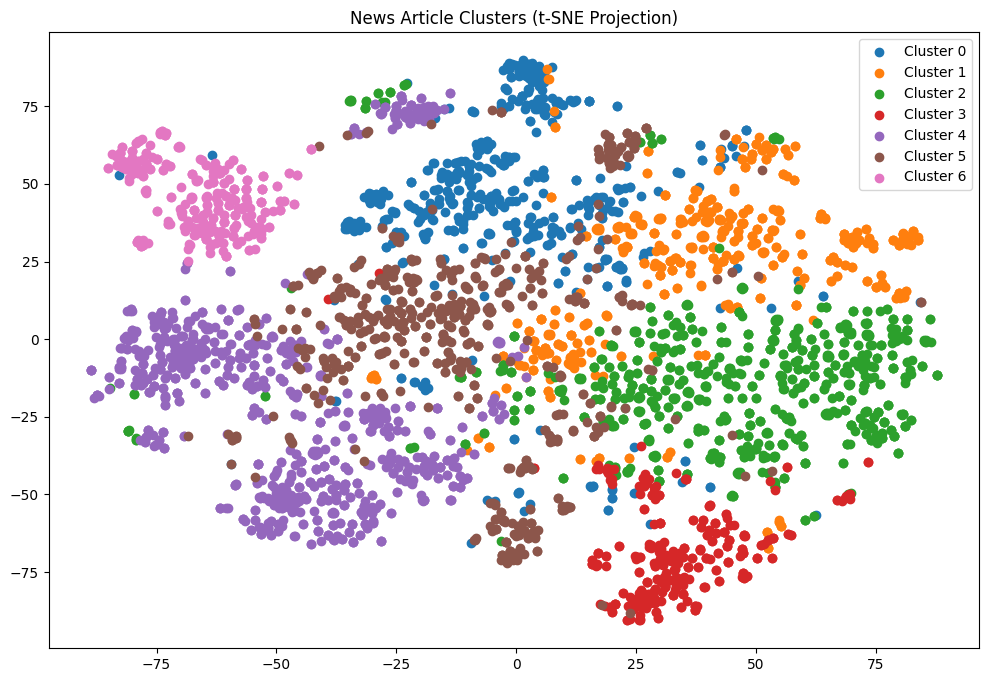

In [ ]:
# %%

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Train final model
final_model = KMeans(n_clusters=optimal_clusters, random_state=Config.SEED)
df["cluster"] = final_model.fit_predict(matrix)

# Create t-SNE visualization
tsne = TSNE(n_components=2, random_state=Config.SEED)
vis_data = tsne.fit_transform(matrix)

plt.figure(figsize=(12,8))
for cluster in range(optimal_clusters):
    plt.scatter(vis_data[df.cluster==cluster, 0], 
                vis_data[df.cluster==cluster, 1],
                label=f'Cluster {cluster}')
plt.legend()
plt.title("News Article Clusters (t-SNE Projection)")
plt.show()

# %% [markdown]

 ## 9. Cluster Labeling

In [ ]:
# %%

for i in range(optimal_clusters):
    print(f"News {i}:", end=" ")

    news = "\n".join(
        df[df.cluster == i].content.sample(5, random_state=42).values
    )
    messages = [
        {
            "role": "user",
            "content": f'Apa kesamaan dari berita-berita berikut ini? (Jawaban singkat (maks 7 kata), tanpa “Tema umum dalam berita-berita ini adalah")\n\nNews:\n"""\n{news}\n"""\n\nTheme:',
        }
    ]

    response = asyncio.run(
        aclient.chat.completions.create(
            model=Config.LLM_MODEL,
            messages=messages,
            temperature=0,
            max_tokens=1000,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
        )
    )

    # Extract the label from the response
    label = response.choices[0].message.content.replace("\n", "")

    # Assign the label to all rows in this cluster
    df.loc[df.cluster == i, "cluster_label"] = label

    print(label)
    sample_cluster_rows = df[df.cluster == i].sample(5, random_state=42)
    for j in range(5):
        print(sample_cluster_rows.title.str[:100].values[j])

    print("-" * 100)

# df["cluster_label"] = df["cluster"].map(dict(enumerate(cluster_labels)))

# print("Generated cluster labels:", cluster_labels)

News 0: Peringatan dan perayaan pada tanggal 18 Desember
Sederet Peringatan 18 Desember, Ada Hari Jadi Kabupaten Banyuwangi
Whoosh Buka Rute Baru Padalarang-Tegalluar, Tarif Rp 50 Ribu
Berebut Minyak "Tanah Suci"
Keluhkan Perang Tarif, 2.500 Ojol dan Kurir se-Jabodetabek Demo Hari Ini!
Terbongkar! Ini Biang Kerok yang Bikin Tiket Pesawat Jadi Mahal Banget
----------------------------------------------------------------------------------------------------
News 1: Ancaman sanksi dan tarif oleh Donald Trump
Trump Ancam Tambah Sanksi Terkait Perang Ukraina, Rusia Bilang Begini
Daftar 9 Kepala Negara yang Untung-Rugi Trump Jadi Presiden AS Lagi
Resmi! Trump Balik Lagi ke X, Singgung Kamala, Xi Jinping, NATO & PD 3
Bos BI Wanti-wanti Kondisi AS Bikin Dunia Makin 'Gelap'
Video: Trump Siap Umumkan Tarif Impor Balasan ke Banyak Negara
----------------------------------------------------------------------------------------------------
News 2: Tarif impor dan hubungan perdagangan antara negara-ne

In [ ]:
# %%

df["x"] = vis_data[:, 0]
df["y"] = vis_data[:, 1]

# %% [markdown]

 ## 10. Save Results